# State of the Union 

QUESTIONS: why did train do better than test?
BEST Parameters: 7 max tree depth and 10,000 max # of trees is good but how come test results are still doing better?

1.   Discovered Random Forest Regression is going to be the best solution for this problem (XGboost overfits for smaller data sets)
2.   Discovered it doesnt matter if we do weekly vesus daily
3. Discovered don't loose a ton of accuracy when moving to the entire PLU codes.
4. Purpose of this notebook:
> **TEST AN ACTUAL FUTURE PREDICTION HOW IT WOULD WORK IN THE REAL WORLD**



# Implementation Notes


*   ALWAYS GET DOUBLE the past data of the differencing weeks you want. Otherwise your data will be CRAP because youll have dropped all the nulls leaving you with barely any information! so if were differencing and shifitng 8 weeks of data we need at least 16 in the initial sql query.




# Imports

In [0]:
#need to import dataframe

#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area

#access the OS system to work with current directories:
import os

#Imports

import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt
import statsmodels.api as sm
from sklearn import metrics
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.despine()
sns.set(rc={'figure.figsize':(15,9)})
%matplotlib inline

#import and clean DF
df = pd.read_csv('drive/My Drive/Capstone_2/data/one_year.csv', index_col= 'invdate', low_memory=False)#all 3000 product codes

Wed Nov  6 14:03:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#import and clean DF
df = pd.read_csv('drive/My Drive/Capstone_2/data/one_year.csv', index_col= 'invdate', low_memory=False)#all 3000 product codes

# Cleaning
Functions


*   Must implement clean_df, melt, predict_df, rf_data in ORDER because they depend on the future functions not being executed yet



In [0]:
def clean_df (df):
  
  ################ FILTERING OUT INVALID PLUs AND RETURNS #################
  print (f'Initial Shape for DF= {df.shape} \nInitial Number of Unique PLUs = {df.item.nunique()}')

  #taking out invalid PLUs (non-items)
  def non_items ():
    #Turning items that have less than 3 numbers into nulls
    df['item'] = df['item'].apply(lambda x: x if sum(char.isdigit() for char in x) > 2 else np.nan)
  
  non_items()

  #dropping any returns because we are predicting demand not returns
  df[df.ordqty < 0] = np.nan

  print (f'\nNumber of nulls after picking out invalid entries = {df.item.isnull().sum()}')
  
  #getting rid of nulls and irrelevant columns
  df.drop(columns= ['route', 'salesman'], inplace= True)
  df.dropna(subset= ['ordqty', 'item'], axis= 0, inplace=True)

  print (f'Number of after dropping nulls (should be zero) = {df.item.isnull().sum()}\n')

  ################ CREATING SOME NEW FEATURES FOR REFERENCE LATER ####################

  #Making index datetime object
  df.index = pd.to_datetime(df.index)
  
  #Creating a normalized Order Qty column
  df['norm_qty'] = df['ordqty'] / df['units']

  #creating a column for the total orders per item
  df['total_qty'] = df.groupby('item')["norm_qty"].transform('sum')

  # #USE IF YOU WANT TO MODEL REVENUE
  # #Creating a revenue column per item per day
  # df['revenue'] = df['shipqty'] * df['price']

  # #creating a column for the total revenue per item
  # df['total_rev'] = df.groupby('item')["revenue"].transform('sum')

  #Creating a label column by splitting off the first phrase from the item's description, and turning them into lower case
  df['label'] = df['desc'].str.split(",").str[0].str.lower()
  df['label'] = df['label'].str.split(" ").str[0].str.lower()

  ############## DROPPING LOW QUANTITY PLU CODES- SET TO 10 ####################
  
  #filtering out any PLUS with less than 10 orders for the entire year
  df['low_quantities'] = df['total_qty'].apply(lambda x: x if x > 10 else np.nan)
  low= df[df['low_quantities'].isnull()]
  total_low_items = low.item.nunique()

  #IF CUSTOMER WANTS A LIST OF LOW ORDERED ITEMS:
  # print ('List of all the PLUs ordered less than 10 times')
  # list(low.item.unique())

  before= df.shape[0] 
  df.dropna(subset= ['low_quantities'], axis= 0, inplace=True)
  print (f'Number of rows/entries lost in DF after dropping lowest quantity PLUs = {before- df.shape[0]}')
  print (f'Number of unique items(PLUs) dropped for low quantity = {total_low_items}\n')
  print('##########################\n')
  print (f'Shape of DF AFTER cleaning up PLUs and low quantity items = {df.shape} \nNumber of Unique PLUs AFTER clean up= {df.item.nunique()}')

  ############## CREATING PIVOT TABLES ####################
  dfday = pd.pivot_table(df, values= "norm_qty", index= "invdate", columns = "item", aggfunc=np.sum, fill_value=0)
  
  #filling in the missing days
  idx = pd.date_range('2018-08-23', '2019-08-23')
  dfday = dfday.reindex(idx, fill_value=0)
  
  #Whoops accidentally did 366 days instead of 365! Let's fix that...
  dfday = dfday[2:] #had to take away two days so the weeks would End on the final day in the data and not create a new week with only 1 day in the week


  #creating a weekly DF
  dfwkly = dfday.resample('7D').sum()

  #resetting indexes to datetime
  dfday.index = pd.to_datetime(dfday.index)
  dfwkly.index = pd.to_datetime(dfwkly.index)

  print (f'\nDaily Shape = {dfday.shape}\nWeekly Shape = {dfwkly.shape}')

  return dfday, dfwkly


In [0]:
dfday, dfwk = clean_df(df)

Initial Shape for DF= (209225, 30) 
Initial Number of Unique PLUs = 2126

Number of nulls after picking out invalid entries = 11805
Number of after dropping nulls (should be zero) = 0

Number of rows/entries lost in DF after dropping lowest quantity PLUs = 2876
Number of unique items(PLUs) dropped for low quantity = 768

##########################

Shape of DF AFTER cleaning up PLUs and low quantity items = (194544, 32) 
Number of Unique PLUs AFTER clean up= 1332

Daily Shape = (364, 1332)
Weekly Shape = (52, 1332)


# Melting & Feature Engineering

In [0]:
def melt(df):
  
  ########### INITIAL MELTING ######################
  df.reset_index(inplace= True) #reset index for melt
  melt = df.melt(id_vars='index', var_name='item', value_name='sales')
  melt = melt.sort_values(['index', 'item'])
  print (f'Number of Rows in the melted dataframe: {melt.shape}')

  # ########## Basic Feature engineering- Dates ####################
  melt2 =  melt.copy()
  melt2['date']= pd.to_datetime(melt2['index']) #converting index to a datetime
  melt2.drop(columns= ['index'], inplace= True)
  num_rows = melt2.shape[0]
  
  # Extracting date features
  melt2['dayofmonth'] = melt2.date.dt.day
  melt2['dayofyear'] = melt2.date.dt.dayofyear
  melt2['dayofweek'] = melt2.date.dt.dayofweek
  melt2['month'] = melt2.date.dt.month
  melt2['year'] = melt2.date.dt.year
  melt2['weekofyear'] = melt2.date.dt.weekofyear
  melt2['is_month_start'] = (melt2.date.dt.is_month_start).astype(int)
  melt2['is_month_end'] = (melt2.date.dt.is_month_end).astype(int)

  #Basic Feature Engineering- lags, differences, and logs-- These tend to help ALOT with time series data 
  melt2['last_wk_sales'] = melt2.groupby(['item'])['sales'].shift(1)
  melt2['last_wk_diff'] = melt2.groupby(['item'])['sales'].diff(1)
  #melt2['log_sales'] = np.log1p(melt2.sales.values)# Converting sales to log(1+sales)
  melt2['2wks_sales'] = melt2.groupby(['item'])['sales'].shift(2)
  melt2['2wks_diff'] = melt2.groupby(['item'])['sales'].diff(2)
  melt2['3wks_sales'] = melt2.groupby(['item'])['sales'].shift(3)
  melt2['3wks_diff'] = melt2.groupby(['item'])['sales'].diff(3)
  melt2['4wks_sales'] = melt2.groupby(['item'])['sales'].shift(4)
  melt2['4wks_diff'] = melt2.groupby(['item'])['sales'].diff(4)
  melt2['5wks_sales'] = melt2.groupby(['item'])['sales'].shift(5)
  melt2['5wks_diff'] = melt2.groupby(['item'])['sales'].diff(5)
  melt2['6wks_sales'] = melt2.groupby(['item'])['sales'].shift(6)
  melt2['6wks_diff'] = melt2.groupby(['item'])['sales'].diff(6)
  melt2['7wks_sales'] = melt2.groupby(['item'])['sales'].shift(7)
  melt2['7wks_diff'] = melt2.groupby(['item'])['sales'].diff(7)
  melt2['8wks_sales'] = melt2.groupby(['item'])['sales'].shift(7)
  melt2['8wks_diff'] = melt2.groupby(['item'])['sales'].diff(7)
  melt2 = melt2.dropna()

  print (f'Number of Rows lost by differencing: {num_rows - melt2.shape[0]}') #how many rows did we loose from the differencing?

  melt2.set_index('date', inplace= True)  

  #Adding Holidays--- these were events discussed with the customer
  melt2["new_years"] = (melt2.index.dayofyear == 1) | (melt2.index.dayofyear >= 359)
  melt2["christmas"] = (melt2.index.month == 12) & ((melt2.index.day >= 15)&(melt2.index.day < 26))
  melt2["thanksgiving"] = (melt2.index.month == 11) & ((melt2.index.day >= 20)&(melt2.index.day <= 29))
  melt2["farm2table"] = (melt2.index.month == 7) & ((melt2.index.day >= 1)&(melt2.index.day <= 15))
  melt2["memorial_day"] = (melt2.index.month == 5) & ((melt2.index.day >= 18)&(melt2.index.day <= 28))
  melt2["back_to_school"] = (melt2.index.month == 8) & ((melt2.index.day >= 10)&(melt2.index.day <= 25))

  return melt2

In [0]:
print ('DF week transformation\n')
dfwk= melt(dfwk)
print ('\nDF day transformation\n')
dfday = melt(dfday)

DF week transformation

Number of Rows in the melted dataframe: (69264, 3)
Number of Rows lost by differencing: 9324

DF day transformation

Number of Rows in the melted dataframe: (484848, 3)
Number of Rows lost by differencing: 9324


# Create a Data Frame for Predictions

In [0]:
#Creating a Dataframe for predictions

def predict_df (df):

  copy = df.copy()  
  lastwk = copy.index[-1]
  new_df = copy.loc[lastwk]#create a dataframe with just the past week

  from datetime import timedelta
  new_df['new_wk'] = lastwk + timedelta(days=7) #adding a week to predict into the future

  #correcting date features
  new_df['dayofmonth'] = new_df.new_wk.dt.day
  new_df['dayofyear'] = new_df.new_wk.dt.dayofyear
  new_df['dayofweek'] = new_df.new_wk.dt.dayofweek
  new_df['month'] = new_df.new_wk.dt.month
  new_df['year'] = new_df.new_wk.dt.year
  new_df['weekofyear'] = new_df.new_wk.dt.weekofyear
  new_df['is_month_start'] = (new_df.new_wk.dt.is_month_start).astype(int)
  new_df['is_month_end'] = (new_df.new_wk.dt.is_month_end).astype(int)

  #correcting lag sales and diffs by shifting everything over by one week
  new_df['last_wk_sales'] = new_df.sales
  new_df['2wks_sales'] = new_df.last_wk_sales
  new_df['2wks_diff'] = new_df.last_wk_diff
  new_df['3wks_sales'] = new_df['2wks_sales']
  new_df['3wks_diff'] = new_df['2wks_diff']
  new_df['4wks_sales'] = new_df['3wks_sales']
  new_df['4wks_diff'] = new_df['3wks_diff']
  new_df['5wks_sales'] = new_df['4wks_sales']
  new_df['5wks_diff'] = new_df['4wks_diff']
  new_df['6wks_sales'] = new_df['5wks_sales']
  new_df['6wks_diff'] = new_df['5wks_diff']
  new_df['7wks_sales'] = new_df['6wks_sales']
  new_df['7wks_diff'] = new_df['6wks_diff']
  new_df['8wks_sales'] = new_df['7wks_sales']
  new_df['8wks_diff'] = new_df['7wks_diff']

  #Re-doing Holidays
  new_df.set_index('new_wk', inplace= True)  
  new_df["new_years"] = (new_df.index.dayofyear == 1) | (new_df.index.dayofyear >= 359)
  new_df["christmas"] = (new_df.index.month == 12) & ((new_df.index.day >= 15)&(new_df.index.day < 26))
  new_df["thanksgiving"] = (new_df.index.month == 11) & ((new_df.index.day >= 20)&(new_df.index.day <= 29))
  new_df["farm2table"] = (new_df.index.month == 7) & ((new_df.index.day >= 1)&(new_df.index.day <= 15))
  new_df["memorial_day"] = (new_df.index.month == 5) & ((new_df.index.day >= 18)&(new_df.index.day <= 28))
  new_df["back_to_school"] = (new_df.index.month == 8) & ((new_df.index.day >= 10)&(new_df.index.day <= 25))

  #dropping columns and reformatting
  new_df.reset_index(inplace= True)
  new_df.drop(columns= ['sales', 'last_wk_diff','new_wk'], inplace=True) 
  new_df.set_index('item', inplace=True)

  return new_df

In [0]:
#creating the prediction dataframe
df_pred = predict_df(dfwk)

In [0]:
#Getting data ready for RF model

def rf_data (df):

  #Dropping Columns not relevant to a random forest
  df.reset_index(inplace= True)

  #Creating x and y training sets
  x_train = df.drop(['sales', 'last_wk_diff', 'date'], axis=1)
  y_train = df['sales'].values

  df.set_index('item', inplace=True)
  x_train.set_index('item', inplace=True) 

  return x_train, y_train, df

In [0]:
#generate last week before cleaning the dataframe
last_week = dfwk['weekofyear'].iloc[-1]
print (last_week)

#making the data ready for a random forest
x_train, y_train, dfwk = rf_data(dfwk)

33


In [0]:
#Check to see they both have the same number of features!
assert x_train.shape[1] == df_pred.shape[1]

# Baseline Model

In [0]:
#mae metric
def mae(ytrue, ypred):
  return round(mean_absolute_error(ytrue, ypred), 3) 
                                    
#rmse metric function
def rmse(ytrue, ypred):
  return (round(sqrt(mean_squared_error(ytrue, ypred)), 3))

In [0]:
#Restablishing a Naive Baseline and a Validation Split

mean_error = []
for week in range(last_week-5, last_week+1): #setting up six weeks train/validation set
    train = dfwk[dfwk['weekofyear'] < week] 
    val = dfwk[dfwk['weekofyear'] == week]
    
    p = val['last_wk_sales'].values
    
    error = rmse(val['sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
naive_error= np.mean(mean_error)
print('Mean Error = %.5f' % naive_error)

Week 28 - Error 19.34800
Week 29 - Error 20.91000
Week 30 - Error 11.44400
Week 31 - Error 12.79900
Week 32 - Error 13.35000
Week 33 - Error 5.35600
Mean Error = 13.86783


# Train Model

In [0]:
%%time 
rf = RandomForestRegressor(n_estimators=1000, max_depth= 8, n_jobs=-1, random_state=0)
rf.fit(x_train, np.log1p(y_train))
        
p = np.expm1(rf.predict(df_pred))
print (p)

[3.39682391e-03 3.39682391e-03 3.39682391e-03 ... 3.39682391e-03
 2.93509743e-02 6.68890032e+00]
CPU times: user 4min 15s, sys: 251 ms, total: 4min 16s
Wall time: 2min 9s


In [0]:
p = np.expm1(rf.predict(df_pred))
print (p)

[3.39682391e-03 3.39682391e-03 3.39682391e-03 ... 3.39682391e-03
 2.93509743e-02 6.68890032e+00]


In [0]:
weekly_predictions = pd.DataFrame({
    'item': df_pred.index,
    'predicted': p,
})

weekly_predictions= weekly_predictions.round(2)

In [0]:
weekly_predictions.head()

,item,predicted
0,10004PM,0.0
1,10004PS,0.0
2,10005,0.0
3,10005A,0.0
4,10006,0.0


In [0]:
weekly_predictions.sort_values(by= 'predicted', ascending= False)

,item,predicted
992,70114A,437.97
411,20215A,128.87
134,10238,110.68
408,20213,107.70
653,30234-A,106.31
...,...,...
536,25223C,0.00
537,25233,0.00
539,25240,0.00
542,30006,0.00


# COMPARING PREDICTIONS TO ACTUAL AMOUNTS

In [0]:
dfn = pd.read_csv('drive/My Drive/Capstone_2/data/new_info.csv', index_col= 'invdate', low_memory=False)
dfm = pd.read_csv('drive/My Drive/Capstone_2/data/master.csv', index_col= 'invdate', low_memory=False)

In [0]:
dfn.reset_index(inplace= True)
dfm.reset_index(inplace=True)

In [0]:
dfn['invdate'] =  pd.to_datetime(dfn['invdate'], format='%Y/%m/%d')
dfm['invdate'] =  pd.to_datetime(dfm['invdate'], format='%Y/%m/%d')

In [0]:
dfn.dtypes

invdate      datetime64[ns]
invno               float64
item                 object
desc                 object
uom                  object
units               float64
price               float64
totalcost           float64
ordqty              float64
shipqty             float64
amount              float64
custno               object
sono_x              float64
sono_y              float64
paid                float64
duedate              object
days                float64
status               object
datesold             object
delivery             object
priccode             object
orgprice            float64
firstrun            float64
added                object
invline             float64
norm_qty            float64
revenue             float64
total_qty           float64
total_rev           float64
label                object
dtype: object

In [0]:
############## CREATING PIVOT TABLES ####################
dfnday = pd.pivot_table(dfn, values= "norm_qty", index= "invdate", columns = "item", aggfunc=np.sum, fill_value=0)
  
  # #filling in the missing days
  # idx = pd.date_range('2018-08-23', '2019-08-23')
  # dfday = dfday.reindex(idx, fill_value=0)

#creating a weekly DF
dfnwkly = dfnday.resample('7D').sum()

#resetting indexes to datetime
dfnwkly.index = pd.to_datetime(dfnwkly.index)

In [0]:
nxt_wk_actl = dfnwkly.iloc[:1, :]

In [0]:
nxt_wk_actl

item,10007A,10018B,10018D,10027,10027A,10027D,10033B,10036,10037,10040B,10042,10042D,10043C,10043D,10049G,10049H,10056,10056C,10058D,10058F,10068A,10070C,10070H,10074A,10075,10104,10107,10107A,10108F,10109A,10110B,10112,10115,10122,10127,10129D,10131,10135A,10139,10146,...,R10304,R10330,R10343,R10355,R10400,R10428,R10442,R10511,R20144,R20326,R30002,R30024,R30050,R30089,R30103,R30114,R30129,R30143,R30180,R30208,R30233,R30269,R30327,R30480,R30517,R30547,R30557,R30587,R30601,R30634,R30683,R30754,R40008,R50084,R50139,R60013,R70016,SAMPLE,XDCK DEL,_BADITEM
invdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-24,11,0.0,17,0.0,0.0,30.0,0.0,0.0,0,0,0.0,4.0,0.0,12.5,0.0,0,0.0,0,0.0,0,0.0,0.0,27.5,1,1.0,0,0.0,7.5,10,0,0.0,6.0,0,0,0,0,0.0,0.0,7,0,...,0.0,2,0,0,0.0,0,1.0,0.0,1.2,0,0.0,0,1,0.0,0.1,2,0.0,0.0,1,0.0,0.0,0.0,0.0,0,0.0,2.0,0.0,0,0.0,0,0,0.0,4.0,1.0,0.0,1.1,0.5,4,15,2


In [0]:
nxt_wk_actl.reset_index(inplace= True)
melt = nxt_wk_actl.melt(id_vars='invdate', var_name='item', value_name='actual')
melt.head()

,invdate,item,actual
0,2019-08-24,10007A,11.0
1,2019-08-24,10018B,0.0
2,2019-08-24,10018D,17.0
3,2019-08-24,10027,0.0
4,2019-08-24,10027A,0.0


In [0]:
weekly_predictions = weekly_predictions.merge(melt, on='item')

In [0]:
weekly_predictions= weekly_predictions.round()
weekly_predictions.head()

,item,predicted,invdate,actual
0,10007A,16.0,2019-08-24,11.0
1,10018D,2.0,2019-08-24,17.0
2,10027,0.0,2019-08-24,0.0
3,10027A,0.0,2019-08-24,0.0
4,10027D,12.0,2019-08-24,30.0


In [0]:
print (rmse(weekly_predictions.actual.values, weekly_predictions.predicted.values))
print (mae(weekly_predictions.actual.values, weekly_predictions.predicted.values))

9.66
4.512


Text(0.5, 1.0, 'How well did the Random Forest Model Do?')

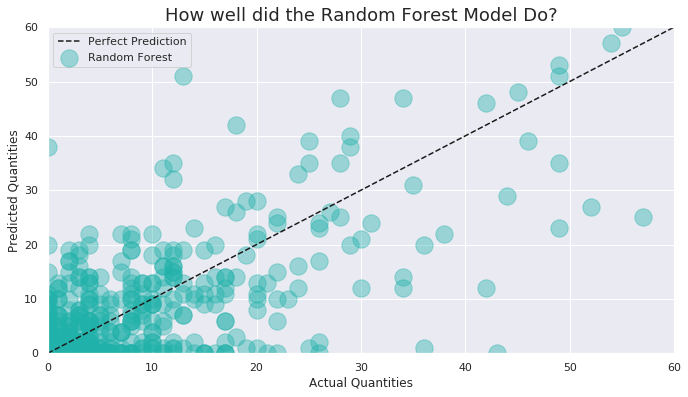

In [0]:
plt.figure(figsize=(10,6))
plt.scatter(weekly_predictions.actual, weekly_predictions.predicted, s=300, color='lightseagreen', alpha= .4, label= "Random Forest")

x = np.linspace(0,60,60)
y = x
plt.plot(x, y, 'k', linestyle='--', label= "Perfect Prediction")
plt.legend()
plt.ylim(0,60)
plt.xlim(0,60)
plt.xlabel('Actual Quantities')
plt.ylabel('Predicted Quantities')
plt.title("How well did the Random Forest Model Do?", fontsize= 18)

In [0]:
grouped= dfn[['item','desc', 'label']]
grouped.drop_duplicates(inplace= True)
grouped.shape
weekly_predictions2 = weekly_predictions.merge(grouped, on='item')

In [0]:
#Which items are doing the worst?
weekly_predictions2['diff']= np.abs(weekly_predictions2.actual- weekly_predictions2.predicted)
bad_predicts = weekly_predictions2.sort_values(by= 'diff', ascending = False)[:100]

In [0]:
bad_predicts

,item,predicted,invdate,actual,desc,label,diff
204,20096,98.0,2019-08-24,4.0,"Kale, Green, 24ct, Certified Organic",kale,94.0
205,20096,98.0,2019-08-24,4.0,"Kale, Green, 24ct, Certified Organi",kale,94.0
727,70176,0.0,2019-08-24,75.0,"Eggs,RETAIL 1 Dzn,COTTONWOOD LOCAL",eggs,75.0
670,60008,86.0,2019-08-24,15.0,"Mushroom, Chantrelle 1 lb. Wild Crafted",mushroom,71.0
671,60008,86.0,2019-08-24,15.0,"Mushroom, Chantrelle 1 lb. Wild Cra",mushroom,71.0
...,...,...,...,...,...,...,...
51,10210,2.0,2019-08-24,14.0,"Plum, Red, 28lb VF, Cert. OG",plum,12.0
88,10318-A,22.0,2019-08-24,10.0,"Grapefruit, Star Ruby,48ct,Cert OG",grapefruit,12.0
491,30492,12.0,2019-08-24,24.0,"Peas, Sugar Snap, 10lb, Cert. OG",peas,12.0
489,30478,13.0,2019-08-24,1.0,"Pea, English 10lb, LOCAL, Cert. OG",pea,12.0


In [0]:
bad_predicts.drop_duplicates(subset= 'item', inplace=True)

In [0]:
bad_predicts.label.unique()

array(['kale', 'eggs', 'mushroom', 'strawberry', 'banana', 'root',
       'squash', 'mango', 'melon', 'salad', 'broccoli', 'peach',
       'cucumber', 'herb', 'edible', 'califia', 'bean', 'juice',
       'avocado', 'apple', 'lemon', 'tomato', 'corn', 'nut', 'orange',
       'milk', 'potato', 'sprouts', 'pineapple', 'lettuce', 'pluot',
       'boc', 'onion', 'grapefruit', 'celery', 'pepper', 'okra',
       'cilantro', 'beet', 'plum', 'peas', 'pea', 'watermelon'],
      dtype=object)

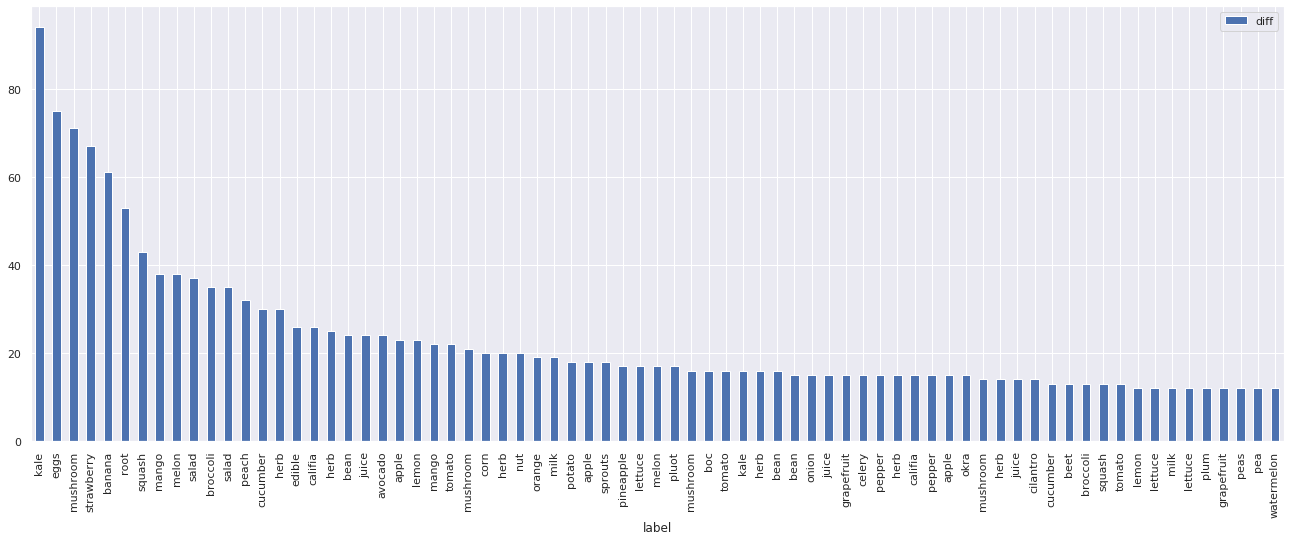

In [0]:
bad_predicts.plot(kind= 'bar', x='label',y='diff', figsize= (20,8))

In [0]:
bad_predicts[bad_predicts.label== 'kale']

,item,predicted,invdate,actual,desc,label,diff
204,20096,98.0,2019-08-24,4.0,"Kale, Green, 24ct, Certified Organic",kale,94.0
200,20084B,6.0,2019-08-24,22.0,"Kale, Mix Baby 2lb, Certified Organ",kale,16.0


In [0]:
bad_predicts[bad_predicts.label== 'eggs']

,item,predicted,invdate,actual,desc,label,diff
727,70176,0.0,2019-08-24,75.0,"Eggs,RETAIL 1 Dzn,COTTONWOOD LOCAL",eggs,75.0


In [0]:
bad_predicts[bad_predicts.label== 'mushroom']

,item,predicted,invdate,actual,desc,label,diff
670,60008,86.0,2019-08-24,15.0,"Mushroom, Chantrelle 1 lb. Wild Crafted",mushroom,71.0
677,60015A,0.0,2019-08-24,21.0,"Mushroom, Crimini 12x8oz, Certified",mushroom,21.0
673,60013,22.0,2019-08-24,38.0,"Mushroom, Crimini 5lb, Certified Or",mushroom,16.0
698,60037,35.0,2019-08-24,49.0,"Mushroom, Shiitake, 5lb, LOCAL, Cert. OG",mushroom,14.0


In [0]:
dfn.head()

In [0]:
dfn.set_index('invdate', inplace= True)


In [0]:
kale= dfm[dfm.label== 'kale']

In [0]:
kale.head()

In [0]:
kale.norm_qty.value_counts()

1.00     2242
2.00      514
0.50      413
3.00      150
4.00       73
5.00       33
6.00       21
7.00       16
10.00      15
8.00       13
15.00      13
9.00        9
12.00       6
17.00       5
18.00       4
14.00       4
11.00       3
1.50        3
21.00       2
26.00       2
44.00       2
20.00       2
19.00       2
56.00       2
35.00       1
30.00       1
45.00       1
43.00       1
59.00       1
0.04        1
24.00       1
34.00       1
25.00       1
22.00       1
52.00       1
36.00       1
13.00       1
61.00       1
Name: norm_qty, dtype: int64